In [16]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load simulation results

In [17]:
# Change the date time to the date time of the pickle file you want to load
date = '230813'
time = '1532'
date_time = date + '_' + time
path = './data/' + date + '/'
data_fanatics = path + date_time + '_fanatics.pkl'
data_fanatics = pd.read_pickle(data_fanatics)

data_no_fanatics = path + date_time + '_no_fanatics.pkl'
data_no_fanatics = pd.read_pickle(data_no_fanatics)

In [18]:
data_fanatics

,P,N,Q,W,A,B,beta,network_threshold,switching_cost,belief_difference,...,CON,CLUSTERING_COEFFICIENT,MEAN_INDEGREE,MEDIAN_INDEGREE,MODE_INDEGREE,MIN_INDEGREE,MAX_INDEGREE,converged_time,network_array,belief_array
0,200,4,1,1,0.005,0.005,0.1,20,0.000001,0.001,...,0.132362,0.271717,4.0,4.0,4.0,0.0,12.0,198.0,"[[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[[0.14285714285714282, 0.9284919314859121, 0.2..."
1,200,4,1,1,0.005,0.005,0.1,20,0.000001,0.001,...,0.124623,0.284945,4.0,4.0,3.0,0.0,12.0,210.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.14285714285714288, 0.8570633600573407, 0.1..."
2,200,4,1,1,0.005,0.005,0.1,20,0.000001,0.001,...,0.203065,0.225770,4.0,4.0,3.0,0.0,15.0,198.0,"[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.07142857144202971, 0.5362592831931574, 0.1..."
3,200,4,1,1,0.005,0.005,0.1,20,0.000001,0.001,...,0.256482,0.200559,4.0,4.0,4.0,0.0,12.0,155.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.07142857142857144, 0.7857142844975914, 0.1..."
4,200,4,1,1,0.005,0.005,0.1,20,0.000001,0.001,...,0.148643,0.229459,4.0,4.0,3.0,0.0,9.0,234.0,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.2142857141640449, 0.7848498715110753, 0.28..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,200,4,1,1,0.005,0.005,1.0,20,0.000001,0.001,...,0.255025,0.109772,4.0,4.0,3.0,0.0,9.0,106.0,"[[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0...","[[0.6000000000000001, 0.9999999996593256, 0.4,..."
86,200,4,1,1,0.005,0.005,1.0,20,0.000001,0.001,...,0.709799,0.071143,4.0,4.0,4.0,0.0,12.0,67.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.5072518566386315, 0.5362592831931574, 0.30..."
87,200,4,1,1,0.005,0.005,1.0,20,0.000001,0.001,...,0.608492,0.063725,4.0,4.0,3.0,0.0,13.0,95.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.6000000000000001, 0.6054190099392188, 0.4,..."
88,200,4,1,1,0.005,0.005,1.0,20,0.000001,0.001,...,0.505980,0.062005,4.0,4.0,3.0,0.0,9.0,54.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.20014843540773888, 0.7848255353280894, 0.6..."


In [19]:
data_fanatics.describe()

,P,N,Q,W,A,B,beta,network_threshold,switching_cost,belief_difference,...,ENLITE,SECTS,CON,CLUSTERING_COEFFICIENT,MEAN_INDEGREE,MEDIAN_INDEGREE,MODE_INDEGREE,MIN_INDEGREE,MAX_INDEGREE,converged_time
count,90.0,90.0,90.0,90.0,9.000000e+01,9.000000e+01,90.000000,90.0,9.000000e+01,9.000000e+01,...,90.000000,90.000000,90.000000,90.000000,90.0,90.000000,90.000000,90.0,90.0000,90.000000
mean,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.550000,20.0,1.000000e-06,1.000000e-03,...,0.496889,3.822222,0.397276,0.114777,4.0,3.983333,3.355556,0.0,11.7000,109.788889
std,0.0,0.0,0.0,0.0,8.722209e-19,8.722209e-19,0.288837,0.0,2.129446e-22,2.180552e-19,...,0.261922,1.632381,0.165553,0.046810,0.0,0.117320,0.865196,0.0,1.3529,40.940761
min,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.100000,20.0,1.000000e-06,1.000000e-03,...,-0.016580,1.000000,0.124623,0.047561,4.0,3.000000,1.000000,0.0,9.0000,53.000000
25%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.300000,20.0,1.000000e-06,1.000000e-03,...,0.374250,3.000000,0.259925,0.076892,4.0,4.000000,3.000000,0.0,11.0000,81.250000
50%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.550000,20.0,1.000000e-06,1.000000e-03,...,0.511704,4.000000,0.377814,0.108916,4.0,4.000000,3.000000,0.0,12.0000,100.500000
75%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.800000,20.0,1.000000e-06,1.000000e-03,...,0.708066,5.000000,0.506432,0.141637,4.0,4.000000,4.000000,0.0,12.0000,132.500000
max,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,1.000000,20.0,1.000000e-06,1.000000e-03,...,0.910080,9.000000,1.000000,0.284945,4.0,4.000000,5.000000,0.0,15.0000,234.000000


In [20]:
data_no_fanatics.describe()

,P,N,Q,W,A,B,beta,network_threshold,switching_cost,belief_difference,...,ENLITE,SECTS,CON,CLUSTERING_COEFFICIENT,MEAN_INDEGREE,MEDIAN_INDEGREE,MODE_INDEGREE,MIN_INDEGREE,MAX_INDEGREE,converged_time
count,10.0,10.0,10.0,10.0,1.000000e+01,1.000000e+01,10.000000,10.0,1.000000e+01,1.000000e+01,...,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.000000,10.0,10.000000,10.00000
mean,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.550000,20.0,1.000000e-06,1.000000e-03,...,0.832281,5.000000,0.225412,0.167884,4.0,4.0,3.600000,0.0,11.400000,111.40000
std,0.0,0.0,0.0,0.0,9.142795e-19,9.142795e-19,0.302765,0.0,2.232128e-22,2.285699e-19,...,0.116395,1.333333,0.052390,0.043158,0.0,0.0,0.966092,0.0,0.699206,26.42894
min,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.100000,20.0,1.000000e-06,1.000000e-03,...,0.550155,3.000000,0.164623,0.119464,4.0,4.0,2.000000,0.0,10.000000,69.00000
25%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.325000,20.0,1.000000e-06,1.000000e-03,...,0.859625,4.000000,0.189221,0.144548,4.0,4.0,3.250000,0.0,11.000000,93.25000
50%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.550000,20.0,1.000000e-06,1.000000e-03,...,0.871891,5.000000,0.214799,0.147799,4.0,4.0,4.000000,0.0,11.500000,109.00000
75%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.775000,20.0,1.000000e-06,1.000000e-03,...,0.876150,5.750000,0.253367,0.183204,4.0,4.0,4.000000,0.0,12.000000,124.50000
max,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,1.000000,20.0,1.000000e-06,1.000000e-03,...,0.931676,7.000000,0.340251,0.267164,4.0,4.0,5.000000,0.0,12.000000,154.00000


## Last network

In [21]:
# Add the last network and belief to the data_fanatics DataFrame
data_fanatics['last_network'] = data_fanatics['network_array'].apply(lambda x: x[-1])
data_fanatics['last_belief'] = data_fanatics['belief_array'].apply(lambda x: x[-1])

In [22]:
# Add the last network and belief to the data_non_fanatics DataFrame
data_no_fanatics['last_network'] = data_no_fanatics['network_array'].apply(lambda x: x[-1])
data_no_fanatics['last_belief'] = data_no_fanatics['belief_array'].apply(lambda x: x[-1])

## In-degree

In [24]:
def get_indegree(network):
    G = nx.from_numpy_array(network, create_using=nx.DiGraph)
    indegree = np.array([G.in_degree(n) for n in G.nodes()])
    return indegree

In [25]:
data_fanatics['last_indegree'] = data_fanatics['last_network'].apply(lambda x: get_indegree(x))
data_no_fanatics['last_indegree'] = data_no_fanatics['last_network'].apply(lambda x: get_indegree(x))

## Split dataset by `fanatics_scheme`

3 datasets
- `fanatics_scheme == 'max'`: all fanatics have a belief of 1.
- `fanatics_scheme == 'min-max'`: half of the fanatics have a belief of 0, the other half have a belief of 1.
- `fanatics_scheme == 'mean'`: all fanatics have a belief of 0.5.

In [26]:
data_fanatics_max = data_fanatics[data_fanatics['fanatics_scheme'] == 'max']
data_fanatics_min_max = data_fanatics[data_fanatics['fanatics_scheme'] == 'min-max']
data_fanatics_mean = data_fanatics[data_fanatics['fanatics_scheme'] == 'mean']

In [27]:
# For each fanatics scheme, we concat the results of the simulations with fanatics and the results of the simulations without fanatics.
fanatics_max = pd.concat([data_no_fanatics, data_fanatics_max])
fanatics_min_max = pd.concat([data_no_fanatics, data_fanatics_min_max])
fanatics_mean = pd.concat([data_no_fanatics, data_fanatics_mean])

In [28]:
fanatics_max['fanatics_scheme'] = 'max'
fanatics_min_max['fanatics_scheme'] = 'min-max'
fanatics_mean['fanatics_scheme'] = 'mean'

In [29]:
fanatics_max.shape, fanatics_min_max.shape, fanatics_mean.shape

((40, 30), (40, 30), (40, 30))

# Visualize

## Network-belief coevolution

### Helper functions

In [34]:
def visualize_beliefs_helper(beliefs: np.ndarray, ax: plt.Axes) -> plt.figure:
    """
    Visualize clusters of beliefs in different periods of the network. 
    This is the core function behind Graeme's Figure 1+4.

    People in the same subnetwork tend to have the same beliefs

    Params:
        beliefs (np.ndarray): The belief of each person in the network
        conv (int): the current period of the simulation. If 0, don't show. If -1, "converged".
        ax (plt.Axes): the figure's axes instance

    Returns:
        fig: The figure of the belief of people (in Graeme's paper)
    """
    # Sort belief and plot
    sorted_b = np.sort(beliefs)[::-1]

    # Plot figure
    ax.set_box_aspect(1/3)
    fig = ax.barh(list(range(len(sorted_b))), sorted_b, height=1)
    ax.xaxis.set_ticks(np.arange(0, 1.1, 0.2))
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, len(sorted_b))
    ax.yaxis.set_visible(False)
    return fig

def visualize_network_helper(beliefs: np.ndarray, networks: np.ndarray, conv: int, ax: plt.Axes) -> plt.figure:
    """
    Visualize segments/clusters of the network.
    This is the core function behind Graeme's Figure 4.

    Params:
        beliefs (np.ndarray): The belief of each person in the network
        networks (np.ndarray): The network of people
        conv (int): The current period of the simulation
        ax (plt.Axes): the figure's axes instance

    Returns:
        fig: The figure of the networks of people
    """
    # Sort people according to beliefs
    members = np.argsort(np.argsort(beliefs))
    # Convert matrix to dictionary
    network = {i: np.where(networks[i] == 1) for i in range(networks.shape[0])}
    # Reindex people according to sorted beliefs
    sort_network = {members[i]: [members[fr]
                                 for fr in network[i]] for i in range(len(members))}

    # Create array for scatter plot
    sort_y = np.array([[y, y, y, y]
                      for y in list(sort_network.keys())]).flatten()
    sort_x = np.array(list(sort_network.values())).flatten()

    # Plot figure
    ax.set(xlim=(0, np.max(sort_x)), ylim=(np.max(sort_y), 0))
    ax.set_box_aspect(1)
    fig = ax.scatter(sort_x, sort_y, 0.2)
    conv = str(conv) if conv != -1 else "converged"
    ax.set_xlabel(f"t = {conv}")
    ax.tick_params(labelbottom='off')
    ax.yaxis.set_visible(False)

    return fig

def visualize_coevolution(results: pd.DataFrame, fanatics_scheme: str, beta: float, export=False) -> plt.figure:
    """
    Graeme's Figure 4: Coevolution of Beliefs and Networks

    Params:
        results (pd.DataFrame): The results of the simulations
        beta (float): Social dissonance value
        export (bool): Export this figure if `true`
        name (str): the OUTPUT_NAME of this program

    Returns:
        fig: The figure of networks & beliefs coevolution (in Graeme's paper)
    """
    # 10 different graphs for 10 fanatic values
    fig, axs = plt.subplots(nrows=4, ncols=8, gridspec_kw={'width_ratios': [1, 3, 1, 3, 1, 3, 1, 3]}, figsize=(15, 8))

    # Loop through different values of num_fanatics
    for i, num_fanatics in enumerate(results['num_fanatics'].unique()):
        df = results[(results['num_fanatics'] == num_fanatics)
                     & (results['beta'] == beta)]

        # Visualize belief at 4 different time steps
        timesteps = [1, 5, 25, -1]

        for j, time in enumerate(timesteps):
            visualize_network_helper(df['belief_array'].iloc[0][j],
                                     df['network_array'].iloc[0][j],
                                     time, axs[j, (i % 4)*2])
            # df['belief_array] is a list of np.ndarray of beliefs at time t
            visualize_beliefs_helper(df['belief_array'].iloc[0][j],
                                     axs[j, (i % 4)*2+1])

        axs[i // 4, (i % 4)*2].set_title(f"Fanatics = {num_fanatics}")
    
    scheme = ''
    if fanatics_scheme == 'max':
        scheme = 'All fanatics hold the highest beliefs'
    elif fanatics_scheme == 'min-max':
        scheme = 'Half of the fanatics hold the highest beliefs, the other half hold the lowest beliefs'
    elif fanatics_scheme == 'mean':
        scheme = 'All fanatics hold the beliefs in the middle'
    fig.suptitle(f"Coevolution of beliefs and networks \n ({scheme}) \n (beta = {round(beta, 2)})")
    plt.tight_layout()

    # Save figure
    if export:
        try:
            os.mkdir(f'./plots/{date}')
        except FileExistsError:
            pass
        plt.savefig(f'./plots/{date}/{date_time}_coev_{fanatics_scheme}_{round(beta, 2)}.png', facecolor='white')
    plt.close()
    return fig

In [31]:
pd.Series(['belief_array']).describe()

count                1
unique               1
top       belief_array
freq                 1
dtype: object

<AxesSubplot:>

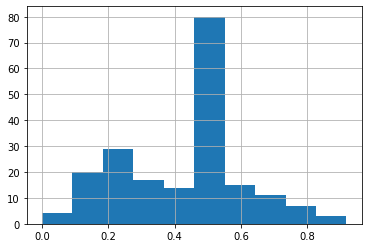

In [32]:
pd.Series(fanatics_mean[(fanatics_mean['beta'] == 0.6) & (fanatics_mean['num_fanatics'] == 60)]['belief_array'][50][0]).hist()

### Results

In [35]:
beta = fanatics_max['beta'].unique()
for b in beta:
    visualize_coevolution(results=fanatics_max, fanatics_scheme='max', beta=b, export=True)

In [36]:
beta = fanatics_min_max['beta'].unique()
for b in beta:
    visualize_coevolution(results=fanatics_min_max, fanatics_scheme='min-max', beta=b, export=True)

In [37]:
beta = fanatics_mean['beta'].unique()
for b in beta:
    visualize_coevolution(results=fanatics_mean, fanatics_scheme='mean', beta=b, export=True)

## In-degree

In [38]:
def visualize_indegree(data: pd.DataFrame, fanatics_scheme: str):
    """Visualize the distribution of in-degrees."""
    scheme = ''
    if fanatics_scheme == 'max':
        scheme = "all fanatics' beliefs=1"
    elif fanatics_scheme == 'min-max':
        scheme = "half of the fanatics' beliefs=1, the other half=0"
    elif fanatics_scheme == 'mean':
        scheme = "all fanatics' beliefs=0.5"

    temp = data.explode('last_indegree')
    palette = sns.color_palette("hls", 10)
    g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
    g_indegree.set_axis_labels('In-degree', 'Count')
    g_indegree.set_titles('Number of fanatics: {col_name}')
    g_indegree.fig.suptitle(f'Distribution of in-degrees ({scheme})', y=1.05)
    plt.legend(title='beta', labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    # g_indegree.savefig(f'./plots/{date_time}_indegree_{fanatics_scheme}.png')
    plt.show(g_indegree)

In [ ]:
visualize_indegree(fanatics_max, fanatics_scheme='max')

In [ ]:
visualize_indegree(fanatics_min_max, fanatics_scheme='min-max')

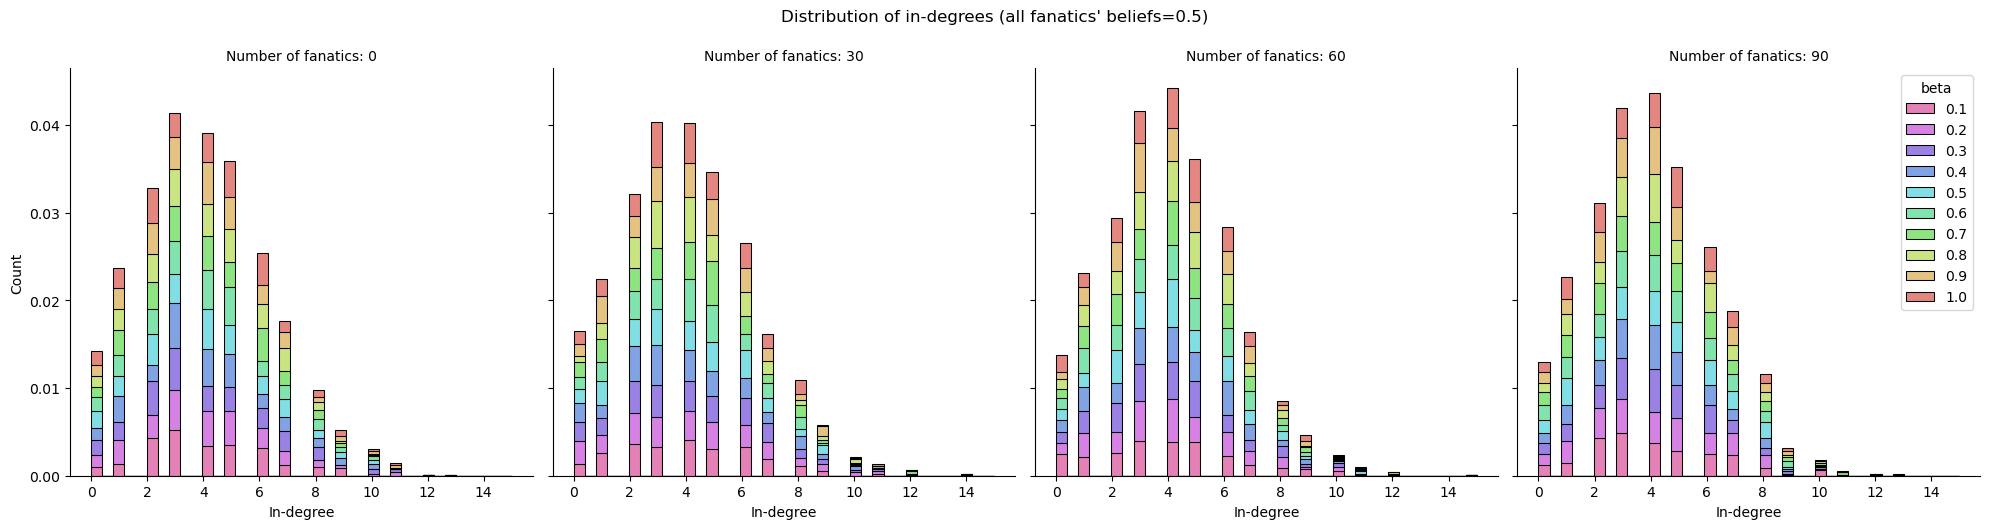

In [ ]:
visualize_indegree(fanatics_mean, fanatics_scheme='mean')

## Metrics

In [ ]:
metrics= ['MEAN', 'STDEV', 'BIAS', 'ENLITE', 'SECTS', 'CON', 'CLUSTERING_COEFFICIENT', 'MEAN_INDEGREE','MEDIAN_INDEGREE', 'MODE_INDEGREE', 'MIN_INDEGREE', 'MAX_INDEGREE']

In [ ]:
# sns.relplot(
#     data=data, x='beta', y='CON', col="num_fanatics", col_wrap=4, kind="line")
# plt.show()

In [ ]:
def line_plot(data, metric):
    """
    Create a line plot of the metric over the beta values.
    """
    sns.lineplot(data=data, x='beta', y=metric, hue='num_fanatics')
    plt.title(f'{metric} vs. beta')
    plt.show()

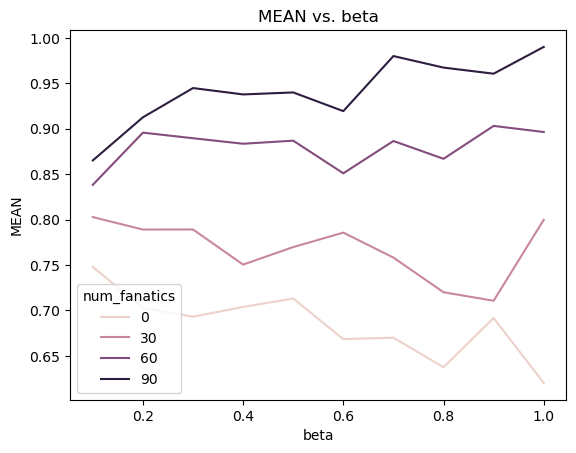

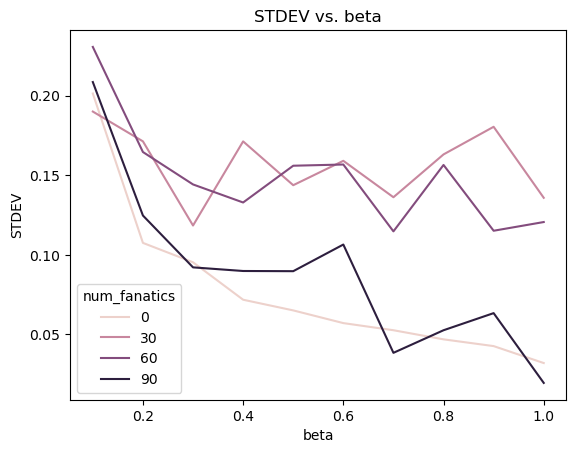

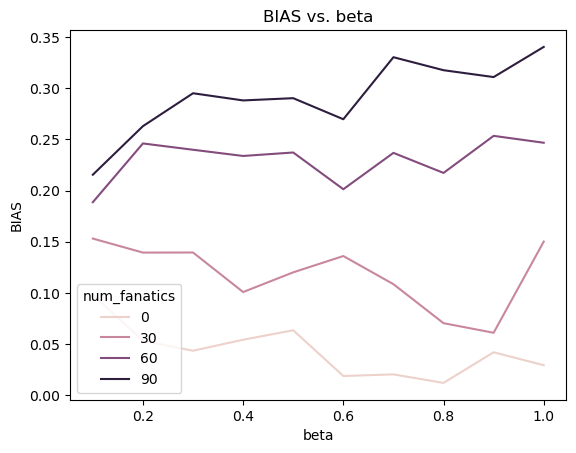

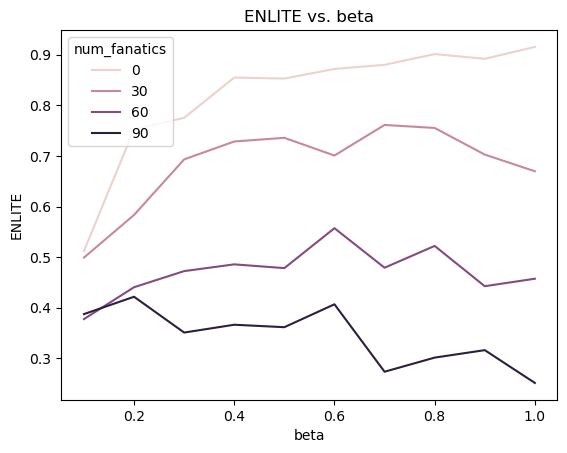

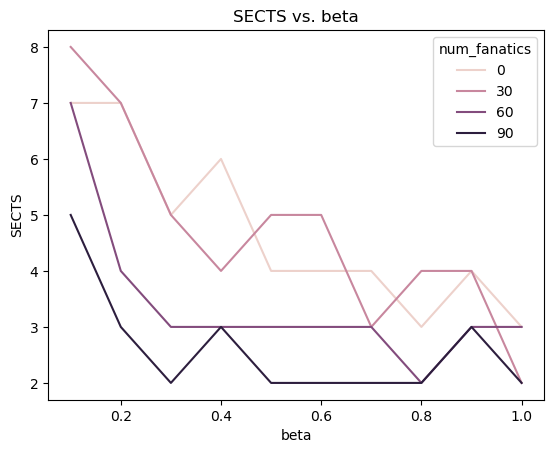

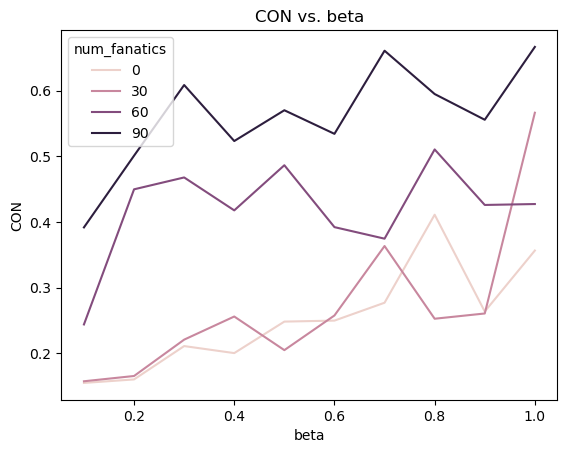

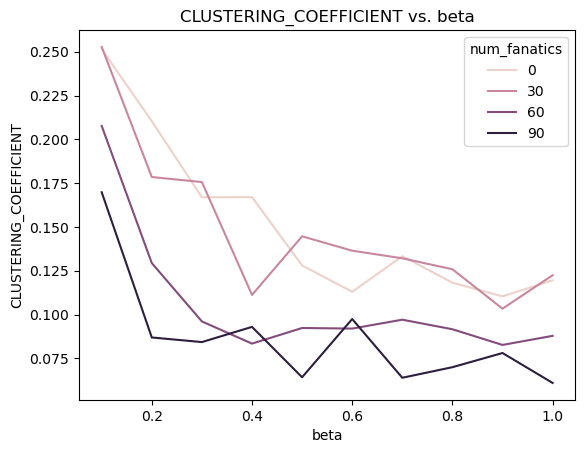

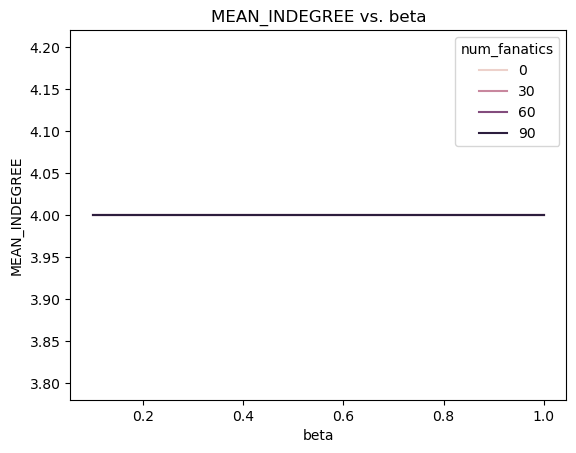

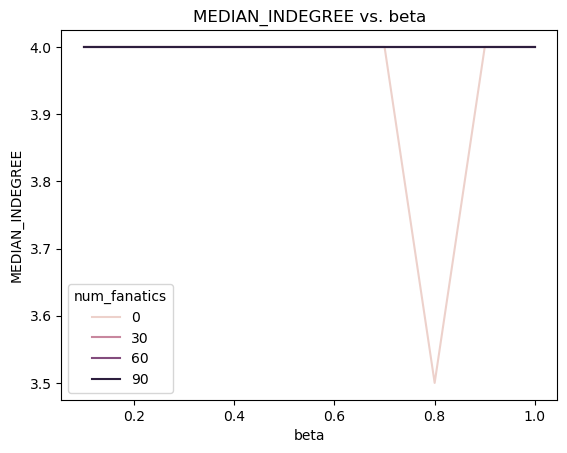

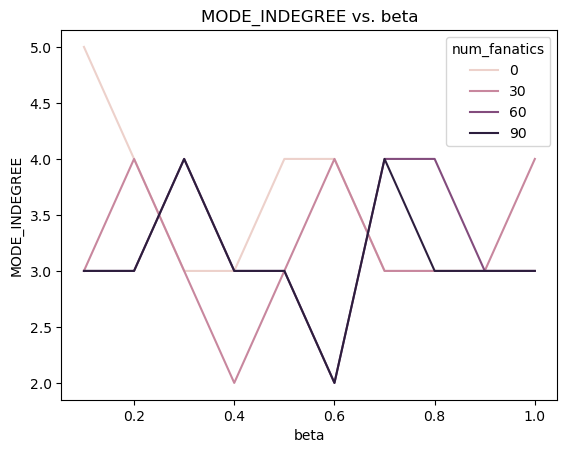

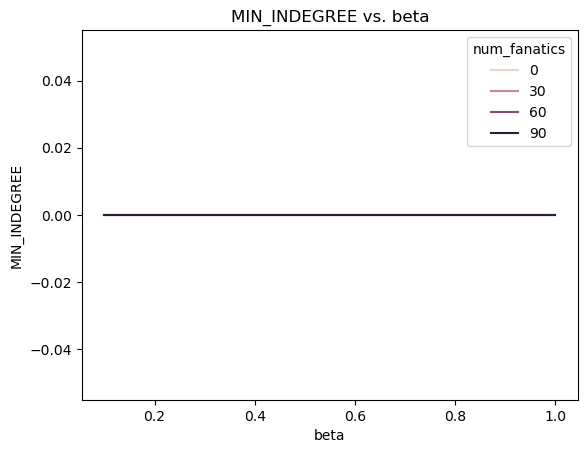

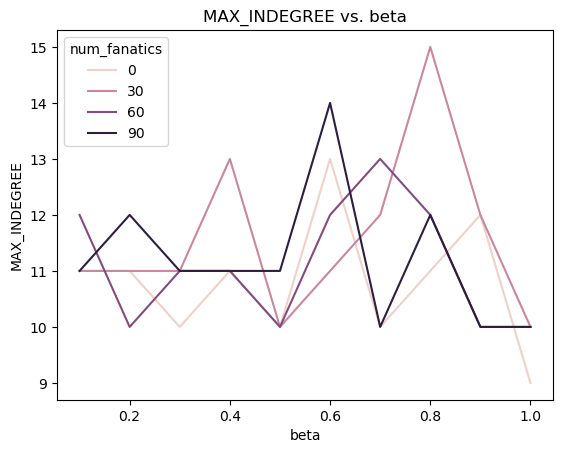

In [ ]:
for metric in metrics:
    line_plot(fanatics_max, metric)

# Do the same thing for other fanatics schemes

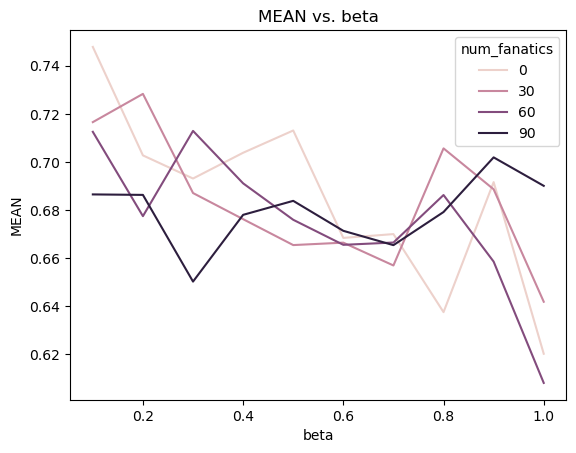

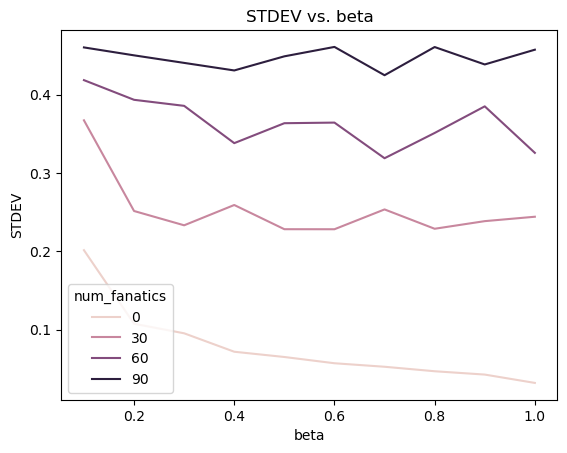

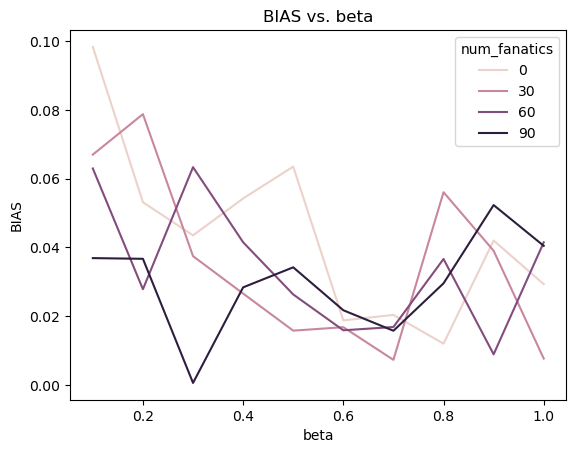

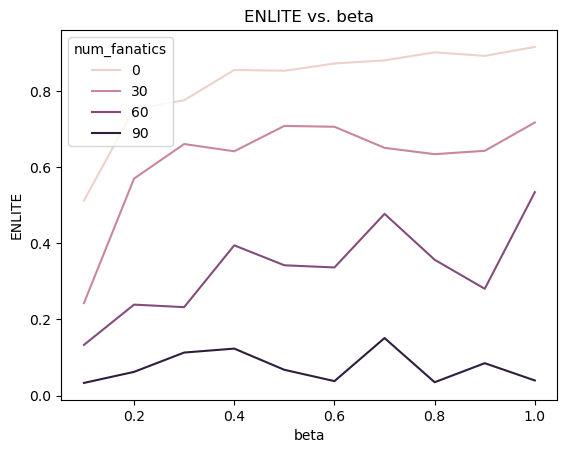

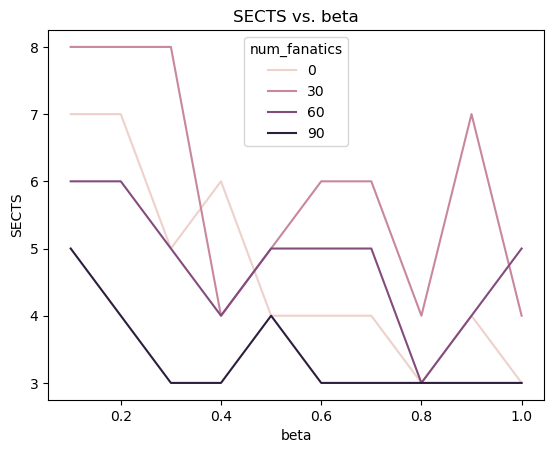

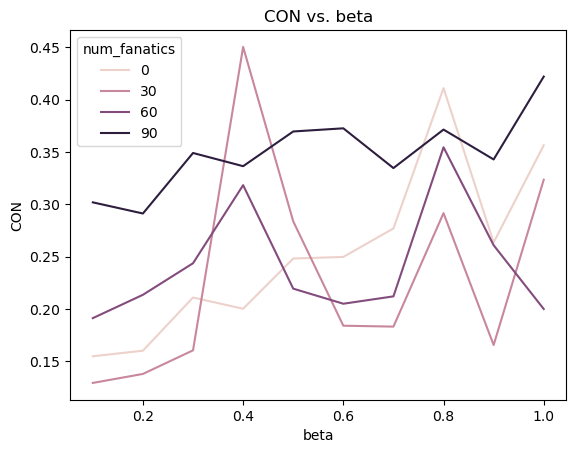

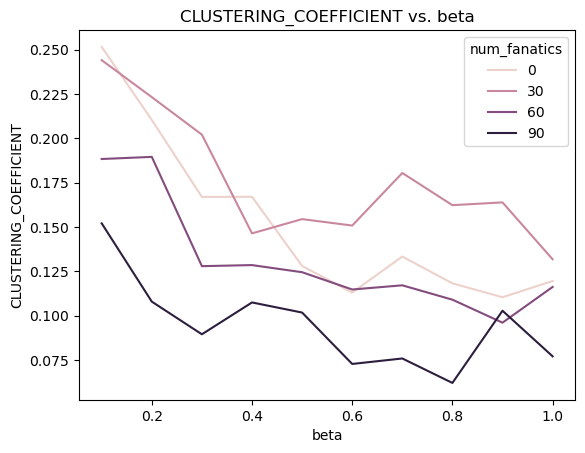

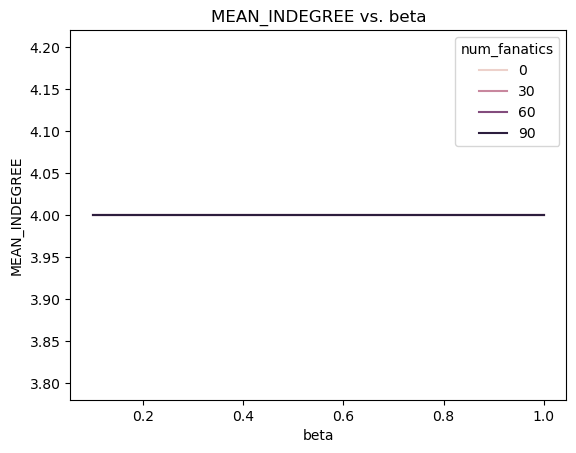

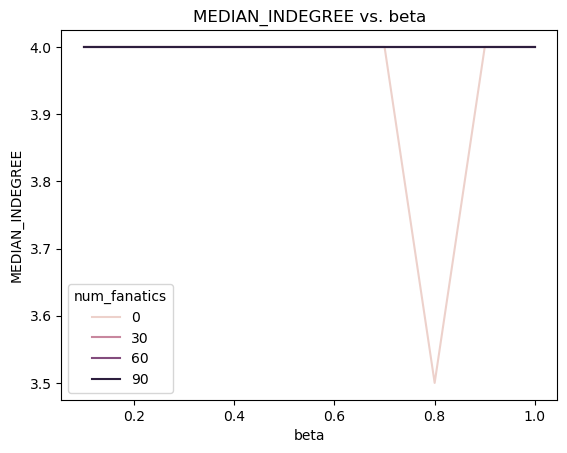

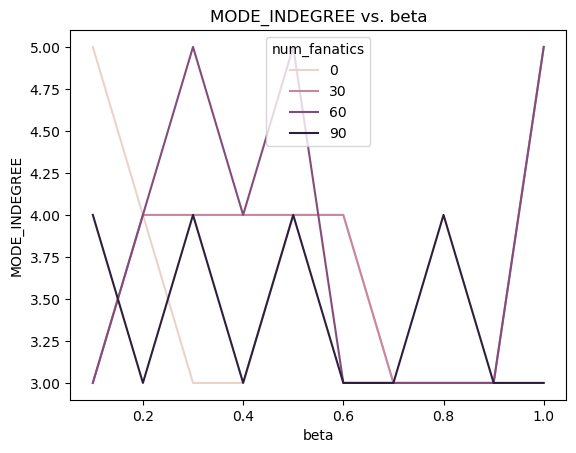

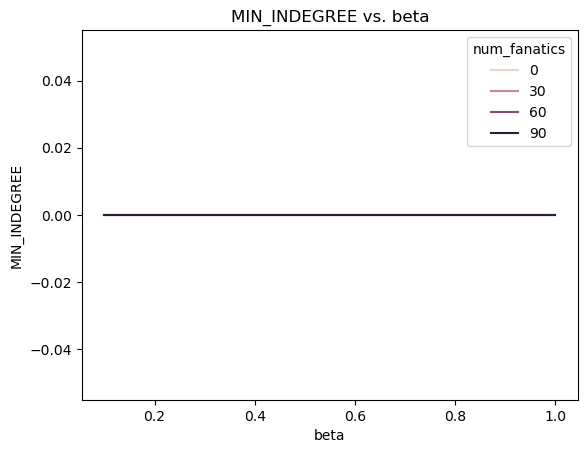

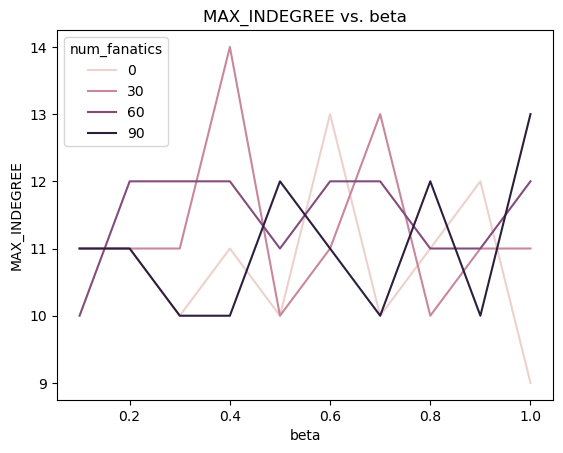

In [ ]:
for metric in metrics:
    line_plot(fanatics_min_max, metric)

# Do the same thing for other fanatics schemes

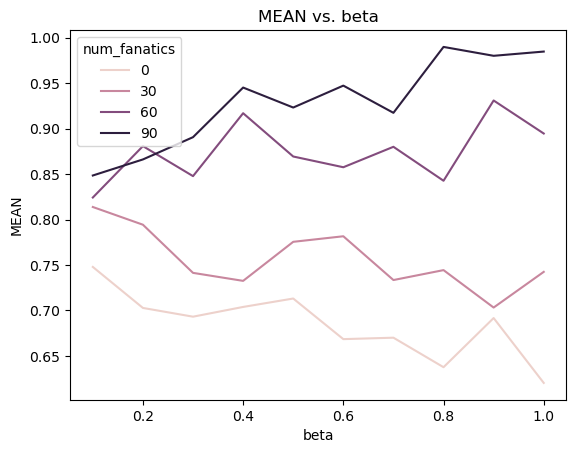

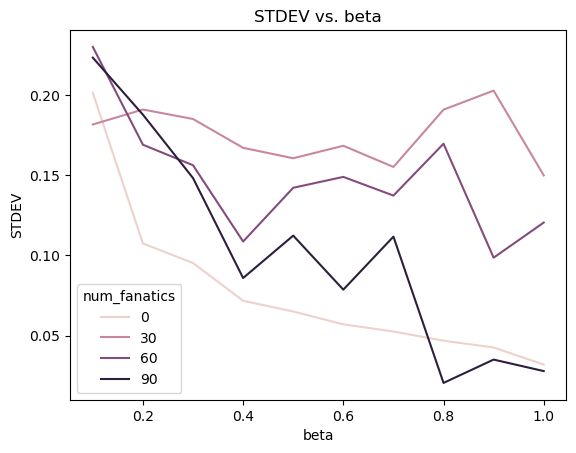

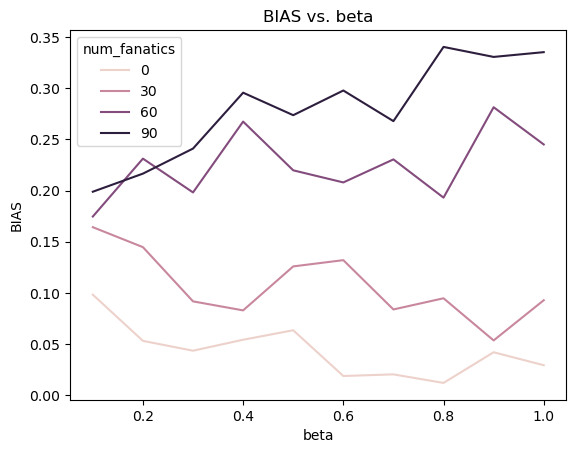

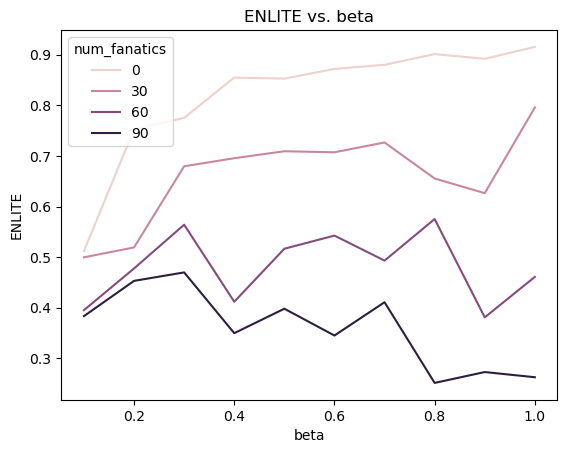

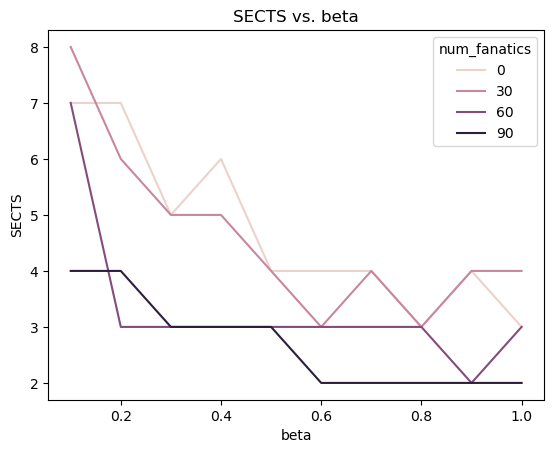

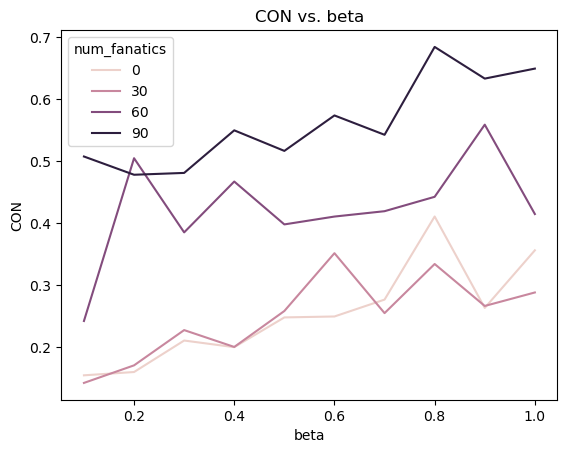

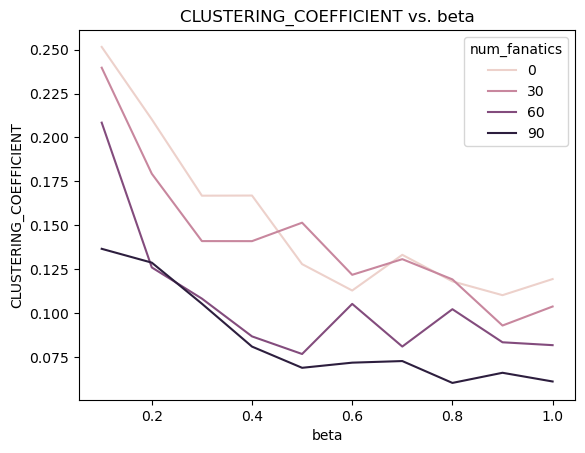

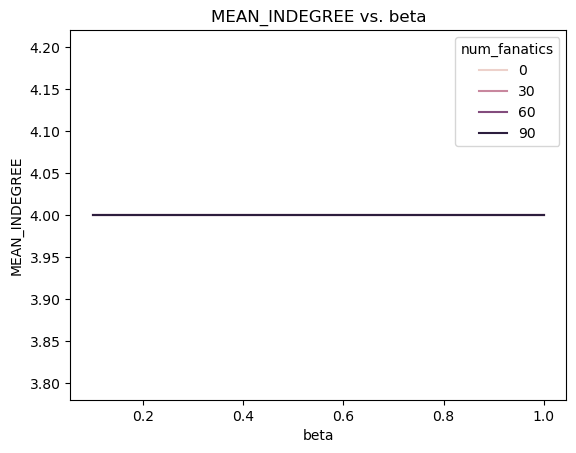

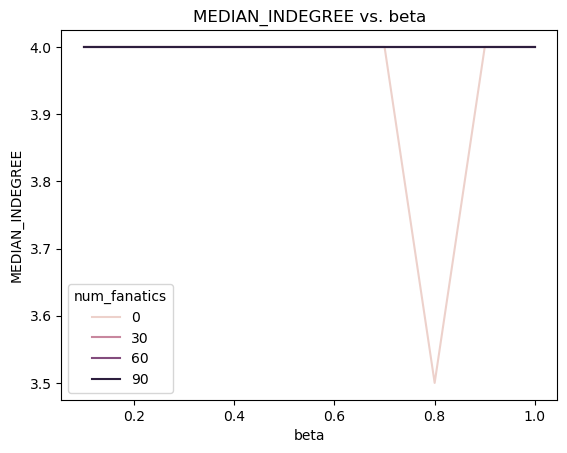

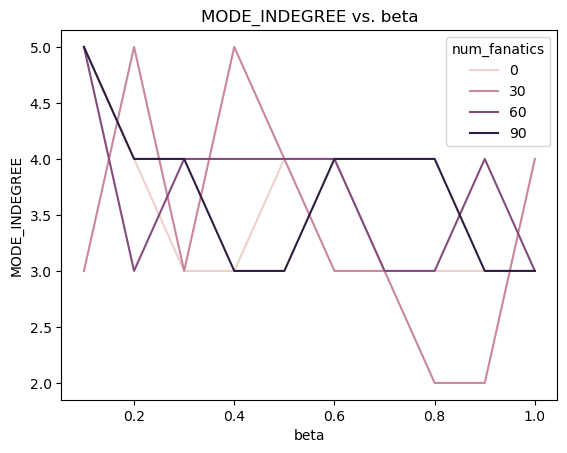

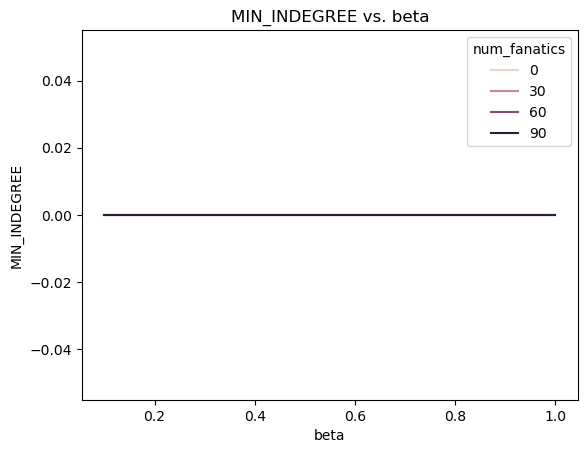

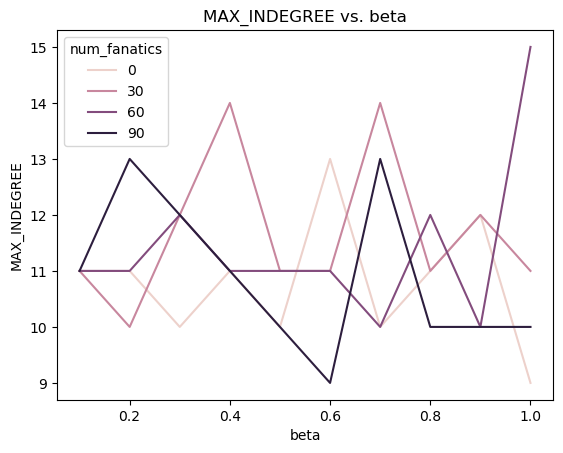

In [ ]:
for metric in metrics:
    line_plot(fanatics_mean, metric)

# Do the same thing for other fanatics schemes